In [1021]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statistics as st 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.compose import make_column_selector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
import category_encoders as ce

# EDA

In [1022]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### planning_area & subzone NA value in test dataset

In [1023]:
emptyPA = test[test['planning_area'].isna()]
emptyPA['address'].unique()

array(['1 tessensohn road', '38 lorong 32 geylang', '17 farrer drive',
       '5 jalan mutiara'], dtype=object)

In [1024]:
missingPA = pd.read_csv('auxiliary-data/missingPAdata.csv')
missingPA.head()

,address,planning_area,subzone
0,1 tessensohn road,kallang,boon keng
1,38 lorong 32 geylang,geylang,aljunied
2,15 farrer drive,tanglin,chatsworth
3,17 farrer drive,tanglin,chatsworth
4,5 jalan mutiara,tanglin,nassim


In [1025]:
s = missingPA.set_index('address')['planning_area']
test['planning_area']=test['planning_area'].fillna(test['address'].map(s))

In [1026]:
s = missingPA.set_index('address')['subzone']
test['subzone']=test['planning_area'].fillna(test['subzone'].map(s))

In [1027]:
test.count()

listing_id              6966
title                   6966
address                 6964
property_name           6966
property_type           6966
tenure                  6329
built_year              6608
num_beds                6931
num_baths               6817
size_sqft               6966
floor_level             1156
furnishing              6966
available_unit_types    6446
total_num_units         5066
property_details_url    6966
lat                     6966
lng                     6966
elevation               6966
subzone                 6966
planning_area           6966
dtype: int64

#### planning & subzone in train dataset

In [1028]:
data = train[train['planning_area'].isna()]
data['address'].unique()

array(['1 tessensohn road', '15 farrer drive', '17 farrer drive',
       '38 lorong 32 geylang', '5 jalan mutiara'], dtype=object)

In [1029]:
s = missingPA.set_index('address')['planning_area']
train['planning_area']=train['planning_area'].fillna(train['address'].map(s))

In [1030]:
s = missingPA.set_index('address')['subzone']
train['subzone']=train['planning_area'].fillna(train['subzone'].map(s))

## Pre-processing

### Remove listing_id  
#### listing_id is all unique without duplicates

In [1031]:
train = train.drop(columns=['listing_id', 'property_details_url', 'elevation','property_name','address','title'])
test = test.drop(columns=['listing_id', 'property_details_url', 'elevation','property_name','address','title'])

# train = train.drop(columns=['property_details_url', 'elevation','property_name','address','title'])

In [1032]:
train.describe()

,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,price
count,19332.000000,20174.000000,19820.000000,2.025400e+04,14602.000000,20254.000000,20254.000000,2.025400e+04
mean,2010.833695,3.122931,2.643542,1.854364e+03,376.253938,1.434282,103.855356,5.228263e+06
std,15.822803,1.281658,1.473835,1.354343e+04,346.882474,1.558472,3.593441,2.779748e+08
min,1963.000000,1.000000,1.000000,0.000000e+00,4.000000,1.239621,-77.065364,0.000000e+00
25%,2000.000000,2.000000,2.000000,8.070000e+02,106.000000,1.307329,103.806576,8.190000e+05
50%,2017.000000,3.000000,2.000000,1.119000e+03,296.000000,1.329266,103.841552,1.680000e+06
75%,2023.000000,4.000000,3.000000,1.528000e+03,561.000000,1.372461,103.881514,3.242400e+06
max,2028.000000,10.000000,10.000000,1.496000e+06,2612.000000,69.486768,121.023232,3.924243e+10


### Adding Distances

#### Add distance to commericial centres

In [1033]:
ccdistance = pd.read_csv('auxiliary-data/sg-commerical-centres.csv')

In [1034]:
# vectorized haversine function
#https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


In [1035]:
# train['cc_distance'] = haversine_np(train['lng'], train['lat'], ccdistance['lng'], ccdistance['lat'])
expected_result = pd.merge(train, ccdistance, on = 'planning_area')
expected_result.head()
train['cc_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# train['cc_distance'] = haversine_np(train['lng'], train['lat'], ccdistance['lng'], ccdistance['lat'])
expected_result = pd.merge(test, ccdistance, on = 'planning_area')
expected_result.head()
test['cc_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [1036]:
ccdistancemean = train['cc_distance'].median()
train['cc_distance']=train['cc_distance'].fillna(ccdistancemean)

ccdistancemean = test['cc_distance'].median()
test['cc_distance']=test['cc_distance'].fillna(ccdistancemean)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cc_distance'>

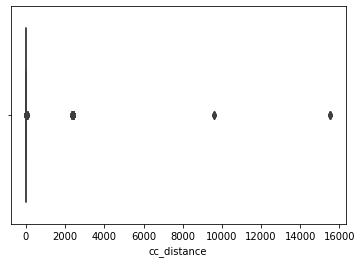

In [1037]:
# Creating plot
sns.boxplot(train['cc_distance'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cc_distance'>

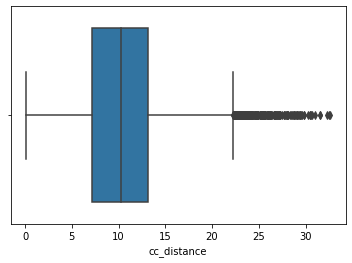

In [1038]:
train.loc[train['cc_distance'] > 2000, 'cc_distance'] = train['cc_distance'].median()
# Creating plot
sns.boxplot(train['cc_distance'])


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cc_distance'>

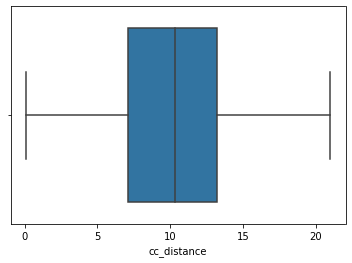

In [1039]:
train.loc[train['cc_distance'] > 21, 'cc_distance'] = 21
# Creating plot
sns.boxplot(train['cc_distance'])


In [1040]:
test.loc[test['cc_distance'] > 21, 'cc_distance'] = 21

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cc_distance'>

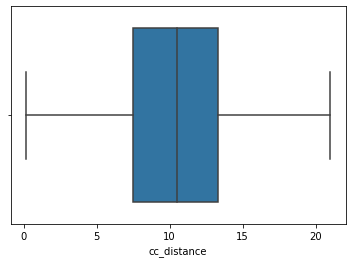

In [1041]:
sns.boxplot(test['cc_distance'])

#### Add distance to mrt stations

In [1042]:
# using long and lat
mrtdistance = pd.read_csv('auxiliary-data/sg-mrt-stations.csv')
expected_result = pd.merge(train, mrtdistance, on = 'planning_area')
train['mrt_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])


# using long and lat
mrtdistance = pd.read_csv('auxiliary-data/sg-mrt-stations.csv')
expected_result = pd.merge(test, mrtdistance, on = 'planning_area')
test['mrt_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [1043]:
mrtdistancemedian = train['mrt_distance'].median()
train['mrt_distance']=train['mrt_distance'].fillna(mrtdistancemedian)

mrtdistancemedian = test['mrt_distance'].median()
test['mrt_distance']=test['mrt_distance'].fillna(mrtdistancemedian)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mrt_distance'>

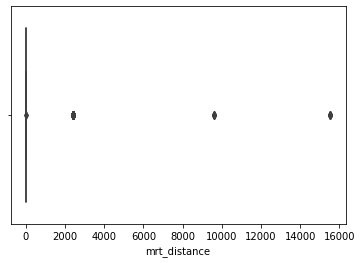

In [1044]:
sns.boxplot(train['mrt_distance'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mrt_distance'>

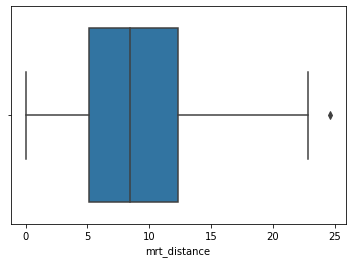

In [1045]:
train.loc[train['mrt_distance'] > 2000, 'mrt_distance'] = train['mrt_distance'].median()
# Creating plot
sns.boxplot(train['mrt_distance'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mrt_distance'>

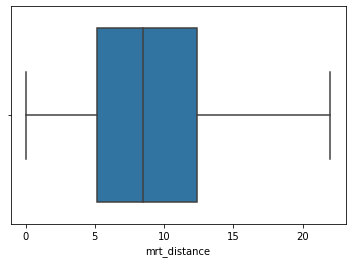

In [1046]:
train.loc[train['mrt_distance'] > 22, 'mrt_distance'] = 22
# Creating plot
sns.boxplot(train['mrt_distance'])

In [1047]:
test.loc[test['mrt_distance'] > 2000, 'mrt_distance'] = test['mrt_distance'].median()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mrt_distance'>

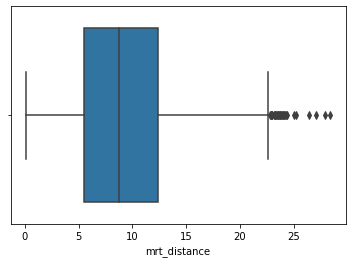

In [1048]:
sns.boxplot(test['mrt_distance'])

#### Add distance to primary school 

In [1049]:
# using long and lat
primaryschooldistance = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
expected_result = pd.merge(train, primaryschooldistance, on = 'planning_area')
train['primary_school_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
primaryschooldistance = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
expected_result = pd.merge(test, primaryschooldistance, on = 'planning_area')
test['primary_school_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [1050]:
pschoolmedian = train['primary_school_distance'].median()
train['primary_school_distance'] = train['primary_school_distance'].fillna(pschoolmedian)

pschoolmedian = test['primary_school_distance'].median()
test['primary_school_distance'] = test['primary_school_distance'].fillna(pschoolmedian)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='primary_school_distance'>

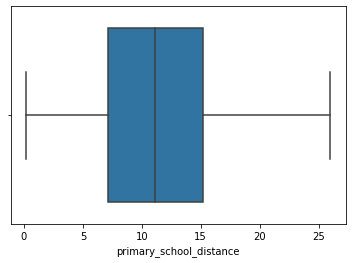

In [1051]:
train.loc[train['primary_school_distance'] > 26, 'primary_school_distance'] = 26
sns.boxplot(train['primary_school_distance'])

In [1052]:
test.loc[test['primary_school_distance'] > 26, 'primary_school_distance'] = 26

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='primary_school_distance'>

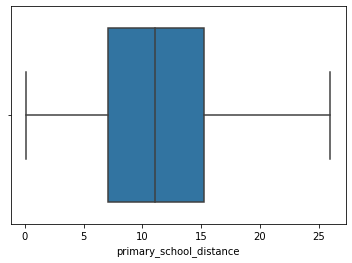

In [1053]:
sns.boxplot(test['primary_school_distance'])

#### Add distance to secondary school

In [1054]:
# using long and lat
secschooldistance = pd.read_csv('auxiliary-data/sg-secondary-schools.csv')
expected_result = pd.merge(train, secschooldistance, on = 'planning_area')
train['secondary_school_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
secschooldistance = pd.read_csv('auxiliary-data/sg-secondary-schools.csv')
expected_result = pd.merge(test, secschooldistance, on = 'planning_area')
test['secondary_school_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [1055]:
sschooldistance = train['secondary_school_distance'].median()
train['secondary_school_distance'] = train['secondary_school_distance'].fillna(sschooldistance)

sschooldistance = test['secondary_school_distance'].median()
test['secondary_school_distance'] = test['secondary_school_distance'].fillna(sschooldistance)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='secondary_school_distance'>

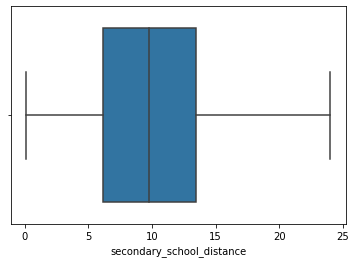

In [1056]:
train.loc[train['secondary_school_distance'] > 24, 'secondary_school_distance'] = 24
sns.boxplot(train['secondary_school_distance'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='secondary_school_distance'>

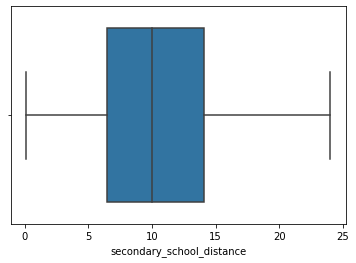

In [1057]:
test.loc[test['secondary_school_distance'] > 24, 'secondary_school_distance'] = 24
sns.boxplot(test['secondary_school_distance'])

#### Add distance to shopping malls

In [1058]:
# using long and lat
shop_distance = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
expected_result = pd.merge(train, secschooldistance, on = 'planning_area')
train['shop_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
shop_distance = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
expected_result = pd.merge(test, secschooldistance, on = 'planning_area')
test['shop_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [1059]:
sdistancemedian = train['shop_distance'].median()
train['shop_distance'] = train['shop_distance'].fillna(sdistancemedian)

sdistancemedian = test['shop_distance'].median()
test['shop_distance'] = test['shop_distance'].fillna(sdistancemedian)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='shop_distance'>

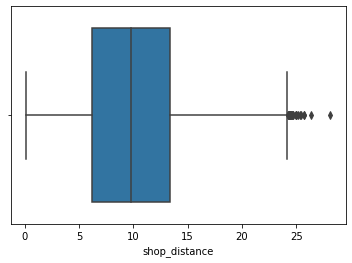

In [1060]:
train.loc[train['shop_distance'] > 2000, 'shop_distance'] = train['shop_distance'].median()
sns.boxplot(train['shop_distance'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='shop_distance'>

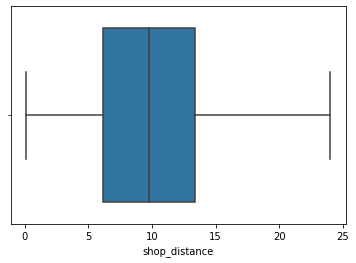

In [1061]:
train.loc[train['shop_distance'] > 24, 'shop_distance'] = 24
sns.boxplot(train['shop_distance'])

In [1062]:
test.loc[test['shop_distance'] > 24, 'shop_distance'] = 24

### lng & lat

In [1063]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,floor_level,furnishing,available_unit_types,total_num_units,lat,lng,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance
0,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,NaN,unspecified,NaN,116.0,1.414399,103.837196,yishun,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065
1,hdb,99-year leasehold,1992.0,4.0,2.0,1575,NaN,unspecified,"1, 2, 3, 4, 5, 6 br",NaN,1.372597,103.875625,serangoon,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202
2,condo,freehold,2022.0,4.0,6.0,3070,low,partial,"studio, 3, 4, 5, 6 br",56.0,1.298773,103.895798,marine parade,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137
3,Condo,freehold,2023.0,3.0,2.0,958,NaN,partial,"studio, 1, 2, 3, 4 br",638.0,1.312364,103.803271,bukit timah,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660
4,condo,99-year leasehold,2026.0,2.0,1.0,732,NaN,unspecified,"studio, 1, 2, 3, 4, 5 br",351.0,1.273959,103.843635,downtown core,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600


In [1064]:
train = train.drop(columns=['lat','lng'])

In [1065]:
test = test.drop(columns=['lat','lng'])

### Population

In [1066]:
population = pd.read_csv('auxiliary-data/sg-subzones.csv')

In [1067]:
expected_result = pd.merge(train, population, on = 'planning_area')
train['population'] = expected_result['population']
train['area_size'] = expected_result['area_size']

In [1068]:
expected_result = pd.merge(test, population, on = 'planning_area')
test['population'] = expected_result['population']
test['area_size'] = expected_result['area_size']

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='population'>

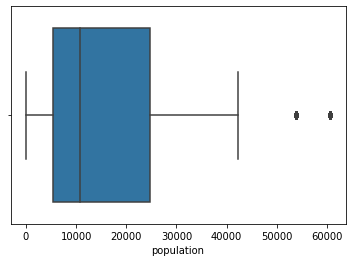

In [1069]:
sns.boxplot(train['population'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='population'>

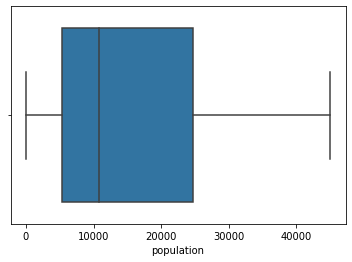

In [1070]:
train.loc[train['population'] > 45000, 'population'] = 45000
sns.boxplot(train['population'])

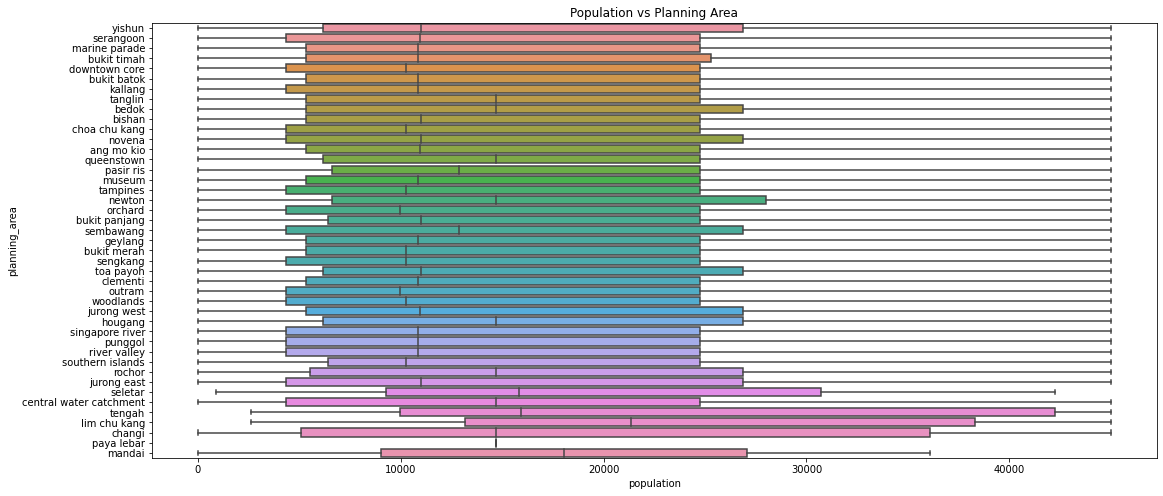

In [1071]:
fig, axes = plt.subplots(figsize=(18,8))
sns.boxplot(x ='population', y= 'planning_area', data=train)
axes.set_title('Population vs Planning Area')
plt.show()

### Area_Size

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='area_size'>

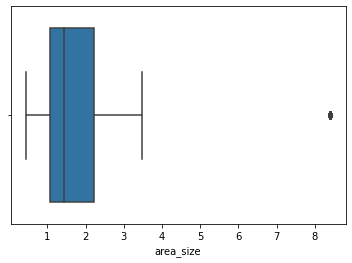

In [1072]:
sns.boxplot(train['area_size'])

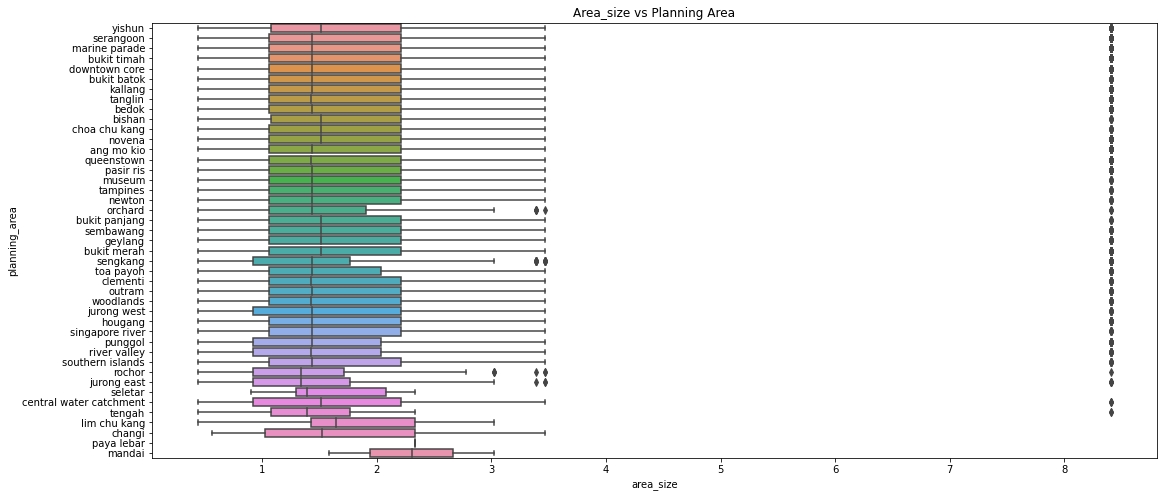

In [1073]:
fig, axes = plt.subplots(figsize=(18,8))
sns.boxplot(x ='area_size', y= 'planning_area', data=train)
axes.set_title('Area_size vs Planning Area')
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='area_size'>

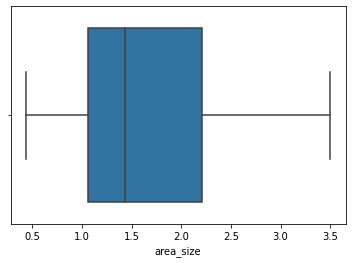

In [1074]:
train.loc[train['area_size'] > 3.5, 'area_size'] = 3.5
sns.boxplot(train['area_size'])

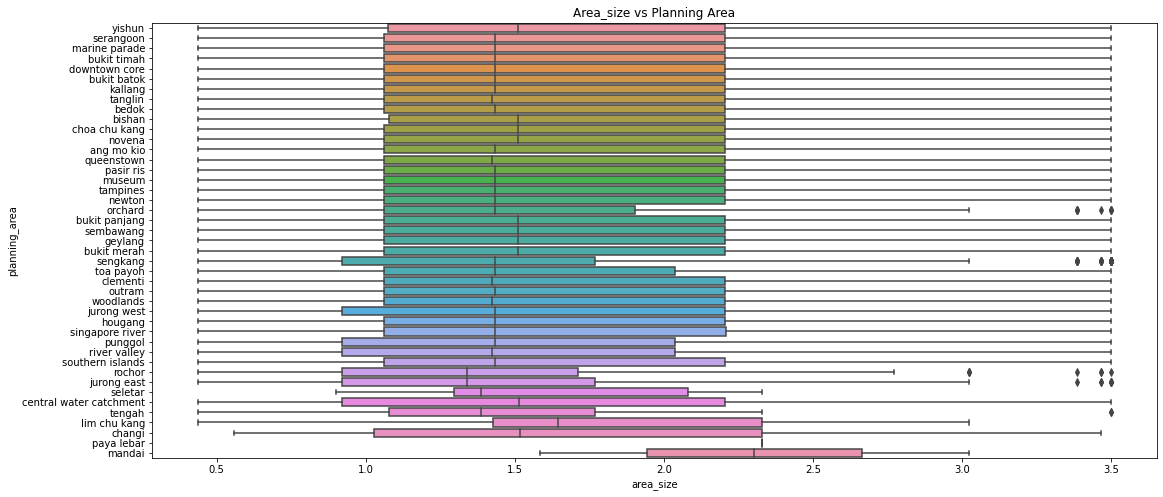

In [1075]:
fig, axes = plt.subplots(figsize=(18,8))
sns.boxplot(x ='area_size', y= 'planning_area', data=train)
axes.set_title('Area_size vs Planning Area')
plt.show()

### Property Type cleaning

In [1076]:
#Change all to uppercase
train['property_type']=train['property_type'].str.upper()

#Change all to uppercase
test['property_type']=test['property_type'].str.upper()

In [1077]:
property_to_keep = test['property_type'].unique()
train.property_type.isin(property_to_keep)

train[~train.property_type.isin(property_to_keep)]

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,floor_level,furnishing,available_unit_types,total_num_units,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
635,LAND ONLY,freehold,2000.0,3.0,3.0,107,NaN,unspecified,"3, 4, 5, 6 br",12.0,tanglin,tanglin,101640000.0,7.065196,9.126171,10.128764,12.080913,12.080913,2620,0.4364
1575,LAND ONLY,99-year leasehold,NaN,5.0,5.0,5726,NaN,unfurnished,"3, 4, 5, 6 br",NaN,bukit panjang,bukit panjang,1257900.0,12.424904,10.844287,14.961924,11.324306,11.324306,10250,1.4329
19090,SHOPHOUSE,freehold,2019.0,2.0,2.0,657,NaN,unspecified,"1, 2 br",17.0,outram,outram,1621100.0,10.309897,1.401878,13.072322,13.021354,13.021354,6440,2.0385


In [1078]:
categories_not_in_test = ['LAND ONLY', 'SHOPHOUSE']
train = train[train['property_type'].isin(categories_not_in_test) == False] 

In [1079]:
train['property_type'] = train['property_type'].replace(
    ['CLUSTER HOUSE', 'CONSERVATION HOUSE', 'LANDED', 'WALK-UP', 'TOWNHOUSE', 'GOOD CLASS BUNGALOW', 'CORNER TERRACE', 'SEMI-DETACHED HOUSE', 'BUNGALOW', 'TERRACED HOUSE'],
    'LANDED'
)

test['property_type'] = test['property_type'].replace(
    ['CLUSTER HOUSE', 'CONSERVATION HOUSE', 'LANDED', 'WALK-UP', 'TOWNHOUSE', 'GOOD CLASS BUNGALOW', 'CORNER TERRACE', 'SEMI-DETACHED HOUSE', 'BUNGALOW', 'TERRACED HOUSE'],
    'LANDED'
)

In [1080]:
train['property_type'] = train['property_type'].replace(
    ['HDB 3 ROOMS', 'HDB 4 ROOMS', 'HDB 5 ROOMS', 'HDB EXECUTIVE', 'HDB 2 ROOMS', 'APARTMENT'],
    'HDB'
)

test['property_type'] = test['property_type'].replace(
    ['HDB 3 ROOMS', 'HDB 4 ROOMS', 'HDB 5 ROOMS', 'HDB EXECUTIVE', 'HDB 2 ROOMS', 'APARTMENT'],
    'HDB'
)

In [1081]:
train['property_type'] = train['property_type'].replace(
    ['EXECUTIVE CONDO'],
    'CONDO'
)

test['property_type'] = test['property_type'].replace(
    ['EXECUTIVE CONDO'],
    'CONDO'
)

In [1082]:
#for regression only
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(train['property_type'])
# train['property_type']=le.transform(train['property_type'])

# test['property_type']=le.transform(test['property_type'])

# one hot endcoding
# pd.get_dummies(train.property_type, prefix='property')

### Tenure 

In [1083]:
train['tenure'] = train['tenure'].replace(
    [
    '99-year leasehold',
    '110-year leasehold',
    '103-year leasehold',
    '102-year leasehold',
    '100-year leasehold',
    ],
    '99-year leasehold'
)

train['tenure'] = train['tenure'].replace(
    [
    '946-year leasehold',
    '999-year leasehold',
    '956-year leasehold',
    '929-year leasehold',
    '947-year leasehold',
    '999-year leasehold'
    ],
    'freehold'
)



test['tenure'] = test['tenure'].replace(
    [
    '99-year leasehold',
    '110-year leasehold',
    '103-year leasehold',
    '102-year leasehold',
    '100-year leasehold',
    ],
    '99-year leasehold'
)

test['tenure'] = test['tenure'].replace(
    [
    '946-year leasehold',
    '999-year leasehold',
    '956-year leasehold',
    '929-year leasehold',
    '947-year leasehold',
    '999-year leasehold',
    ],
    'freehold'
)

In [1084]:
test['tenure'] = test['tenure'].fillna('99-year leasehold')

In [1085]:
train['tenure'] = train['tenure'].fillna('99-year leasehold')

In [1086]:
## Remove NA 
train = train.dropna(subset=['tenure'])

## Remove NA 
test['tenure'] = test['tenure'].fillna('99-year leasehold')

In [1087]:
#for regression only

# from sklearn import preprocessing
# tenurepp = preprocessing.LabelEncoder()
# tenurepp.fit(train['tenure'])
# train['tenure']=tenurepp.transform(train['tenure'])

# test['tenure']=tenurepp.transform(test['tenure'])

### Funishing

In [1088]:
#Assume not specified and na as unfurnished 
train['furnishing'] = train['furnishing'].replace(
    [
    'na',
    'unspecified',
    ],
    'unfurnished'
)

#Assume not specified and na as unfurnished 
test['furnishing'] = test['furnishing'].replace(
    [
    'na',
    'unspecified',
    ],
    'unfurnished'
)

In [1089]:
#Assume not specified and na as unfurnished 
train['furnishing'] = train['furnishing'].replace(
    [
    'fully',
    ],
    'partial'
)

#Assume not specified and na as unfurnished 
test['furnishing'] = test['furnishing'].replace(
    [
    'fully',
    ],
    'partial'
)

In [1090]:
#for regression only

# from sklearn import preprocessing
# furnishing = preprocessing.LabelEncoder()
# furnishing.fit(train['furnishing'])
# train['furnishing']=furnishing.transform(train['furnishing'])

# test['furnishing']=furnishing.transform(test['furnishing'])

### floor_level 

In [1091]:
# Too few data for floor level, we should just take out the column
train = train.drop(columns='floor_level')

# Too few data for floor level, we should just take out the column
test = test.drop(columns='floor_level')

### total_num_units

In [1092]:
mediantotalunit = train['total_num_units'].median()
train['total_num_units'].fillna(mediantotalunit, inplace=True)

mediantotalunit = test['total_num_units'].median()
test['total_num_units'].fillna(mediantotalunit, inplace=True)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_num_units'>

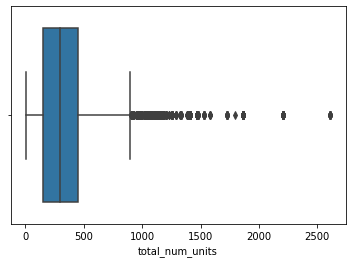

In [1093]:
sns.boxplot(train['total_num_units'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_num_units'>

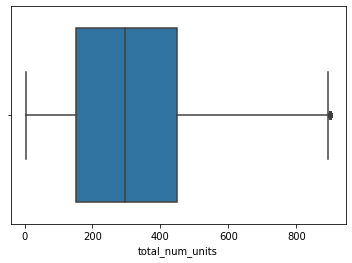

In [1094]:
train.loc[train['total_num_units'] > 900, 'total_num_units'] = 900
# Creating plot
sns.boxplot(train['total_num_units'])

In [1095]:
test.loc[test['total_num_units'] > 900, 'total_num_units'] = 900

In [1096]:
train.count()

property_type                20251
tenure                       20251
built_year                   19330
num_beds                     20171
num_baths                    19817
size_sqft                    20251
furnishing                   20251
available_unit_types         18810
total_num_units              20251
subzone                      20251
planning_area                20251
price                        20251
cc_distance                  20251
mrt_distance                 20251
primary_school_distance      20251
secondary_school_distance    20251
shop_distance                20251
population                   20251
area_size                    20251
dtype: int64

### build year

In [1097]:
train.count()

property_type                20251
tenure                       20251
built_year                   19330
num_beds                     20171
num_baths                    19817
size_sqft                    20251
furnishing                   20251
available_unit_types         18810
total_num_units              20251
subzone                      20251
planning_area                20251
price                        20251
cc_distance                  20251
mrt_distance                 20251
primary_school_distance      20251
secondary_school_distance    20251
shop_distance                20251
population                   20251
area_size                    20251
dtype: int64

In [1098]:
train['built_year'].isnull().sum() / train['built_year'].sum()


2.369472061557495e-05

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='built_year'>

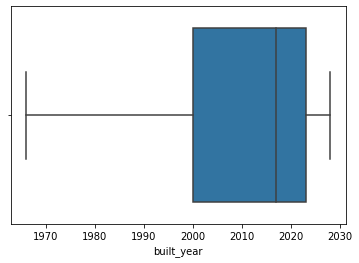

In [1099]:
train.loc[train['built_year'] < 1966, 'built_year'] = 1966
sns.boxplot(train['built_year'])

In [1100]:
avgbuildyear = round(train['built_year'].median(),0)
train['built_year'] = train['built_year'].fillna(avgbuildyear)

avgbuildyear = round(test['built_year'].median(),0)
test['built_year'] = test['built_year'].fillna(avgbuildyear)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='built_year'>

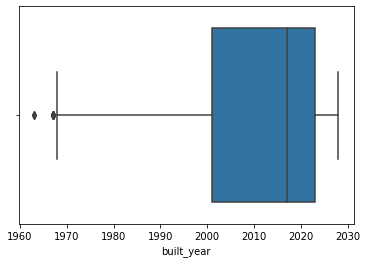

In [1101]:
sns.boxplot(test['built_year'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='built_year'>

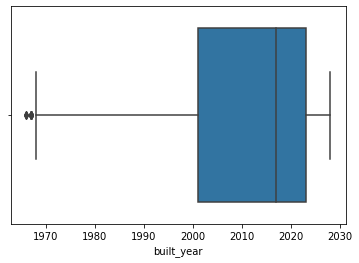

In [1102]:
test.loc[test['built_year'] < 1966, 'built_year'] = 1966
sns.boxplot(test['built_year'])

### num_baths

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_baths'>

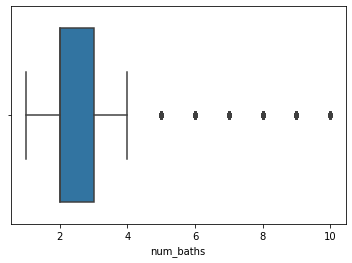

In [1103]:
sns.boxplot(train['num_baths'])

In [1104]:
a = train[train['num_baths'].isna()]
a[a['num_beds'].isna()]

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
3713,LANDED,freehold,1990.0,NaN,NaN,9594,unfurnished,"studio, 1, 4, 5, 6, 7 br",296.0,novena,novena,16275000.0,5.668353,5.872226,6.905858,11.134265,11.134265,2620,0.4364
4691,CONDO,99-year leasehold,2023.0,NaN,NaN,431,unfurnished,"studio, 1, 2, 3, 4, 5, 8 br",774.0,outram,outram,1222200.0,5.825357,8.355056,11.798265,15.372730,15.372730,890,2.2068
4939,HDB,99-year leasehold,1980.0,NaN,NaN,731,unfurnished,NaN,112.0,bedok,bedok,367500.0,15.229001,7.025831,8.583307,13.354867,13.354867,42240,1.3402
5002,HDB,99-year leasehold,2004.0,NaN,NaN,1184,unfurnished,NaN,90.0,punggol,punggol,669900.0,16.664632,6.751215,7.404180,7.477411,7.477411,42240,1.3402
11500,HDB,99-year leasehold,1985.0,NaN,NaN,786,unfurnished,"studio, 2, 3, 4 br",296.0,bukit batok,bukit batok,409500.0,8.707527,4.914059,6.279880,18.454836,18.454836,24760,1.0619


In [1105]:
avgbath = train['num_baths'].median()
train['num_baths'] = train['num_baths'].fillna(avgbath)

avgbath = test['num_baths'].median()
test['num_baths'] = test['num_baths'].fillna(avgbath)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_baths'>

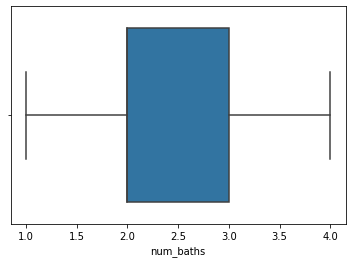

In [1106]:
train.loc[train['num_baths'] > 4, 'num_baths'] = 4
sns.boxplot(train['num_baths'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_baths'>

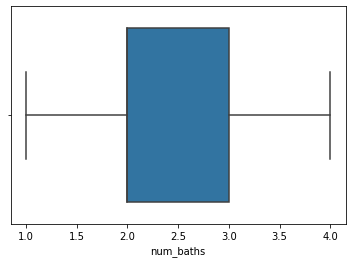

In [1107]:
test.loc[test['num_baths'] > 4, 'num_baths'] = 4
sns.boxplot(train['num_baths'])

### num_beds

In [1108]:
avgbed = train['num_beds'].median()
train['num_beds'] = train['num_beds'].fillna(avgbath)

avgbed = test['num_beds'].median()
test['num_beds'] = test['num_beds'].fillna(avgbath)

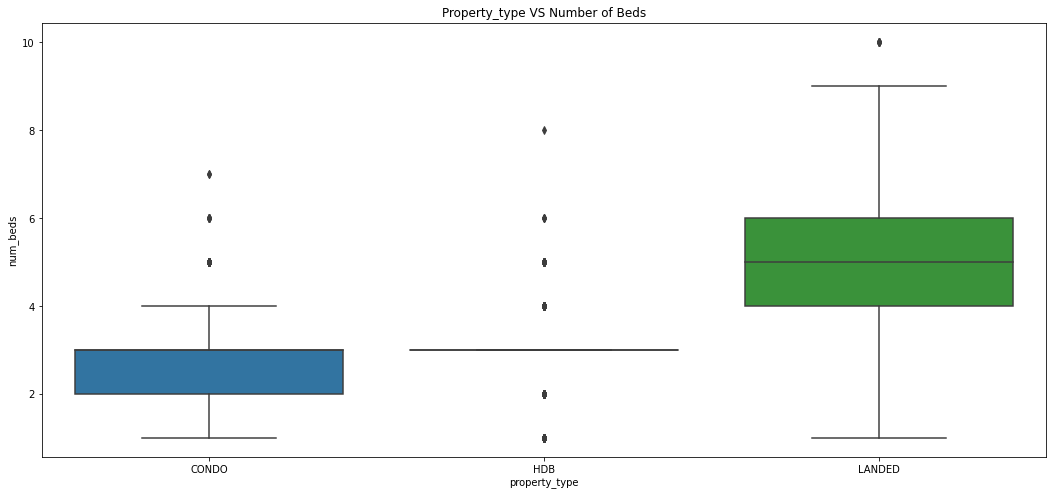

In [1109]:
fig, axes = plt.subplots(figsize=(18,8))
sns.boxplot(x ='property_type', y= 'num_beds', data=test)
axes.set_title('Property_type VS Number of Beds')
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_beds'>

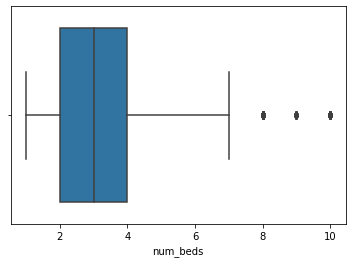

In [1110]:
sns.boxplot(train['num_beds'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_beds'>

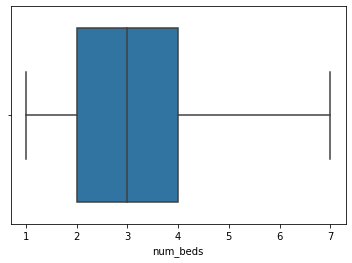

In [1111]:
train.loc[train['num_beds'] > 7, 'num_beds'] = 7
sns.boxplot(train['num_beds'])

### num_avaliable_units

In [1112]:
numavaunittypes = train.available_unit_types.str.count(',') + 1
train['available_unit_types'] = numavaunittypes

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='available_unit_types'>

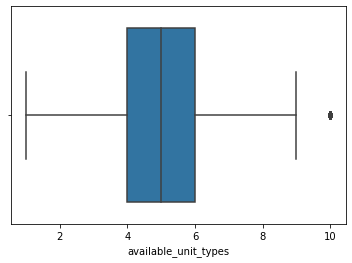

In [1113]:
sns.boxplot(train['available_unit_types'])

In [1114]:
train.loc[train['available_unit_types'] > 9, 'available_unit_types'] = 9

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='available_unit_types'>

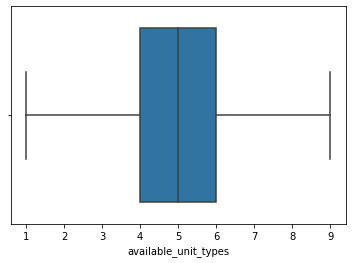

In [1115]:
sns.boxplot(train['available_unit_types'])

In [1116]:
avg_ava_units = train['available_unit_types'].median()
train['available_unit_types'] = train['available_unit_types'].fillna(avg_ava_units)

In [1117]:
numavaunittypes = test.available_unit_types.str.count(',') +1
test['available_unit_types'] = numavaunittypes

In [1118]:
avg_ava_units = test['available_unit_types'].median()
test['available_unit_types'] = test['available_unit_types'].fillna(avg_ava_units)

In [1119]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
0,HDB,99-year leasehold,1988.0,3.0,2.0,1115,unfurnished,5.0,116.0,yishun,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329
1,HDB,99-year leasehold,1992.0,4.0,2.0,1575,unfurnished,6.0,296.0,serangoon,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202,18660,3.5000
2,CONDO,freehold,2022.0,4.0,4.0,3070,partial,5.0,56.0,marine parade,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068
3,CONDO,freehold,2023.0,3.0,2.0,958,partial,5.0,638.0,bukit timah,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110
4,CONDO,99-year leasehold,2026.0,2.0,1.0,732,unfurnished,6.0,351.0,downtown core,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092


In [1120]:
train.dtypes

property_type                 object
tenure                        object
built_year                   float64
num_beds                     float64
num_baths                    float64
size_sqft                      int64
furnishing                    object
available_unit_types         float64
total_num_units              float64
subzone                       object
planning_area                 object
price                        float64
cc_distance                  float64
mrt_distance                 float64
primary_school_distance      float64
secondary_school_distance    float64
shop_distance                float64
population                     int64
area_size                    float64
dtype: object

### price 

Remove price which is 0

In [1121]:
train = train[train['price'] != 0]

In [1122]:
train['log_price'] = np.log(train['price'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_price'>

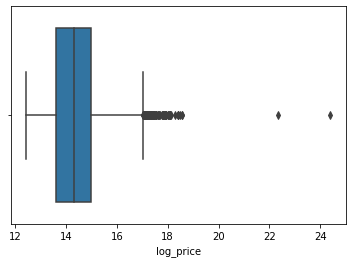

In [1123]:
sns.boxplot(train['log_price'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_price'>

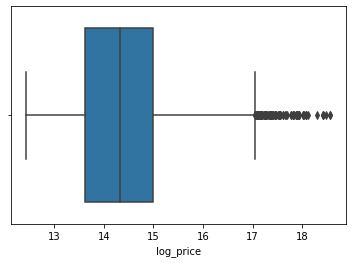

In [1124]:
train = train[train['log_price']<20]
sns.boxplot(train['log_price'])

<AxesSubplot:xlabel='log_price', ylabel='property_type'>

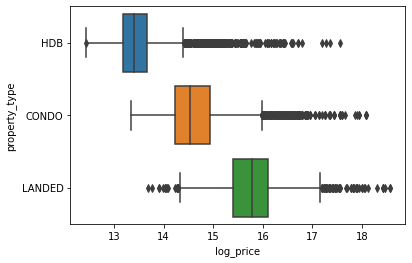

In [1125]:
sns.boxplot(x=train['log_price'], y =train['property_type'])

<AxesSubplot:xlabel='log_price', ylabel='property_type'>

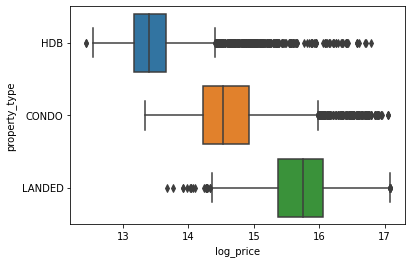

In [1126]:
train = train[train['log_price'] < 17.1]
sns.boxplot(x=train['log_price'], y =train['property_type'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_price'>

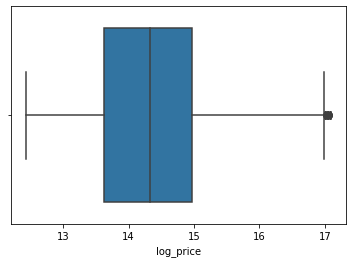

In [1127]:
sns.boxplot(train['log_price'])

In [1128]:
train = train[train['log_price'] <= 17]

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

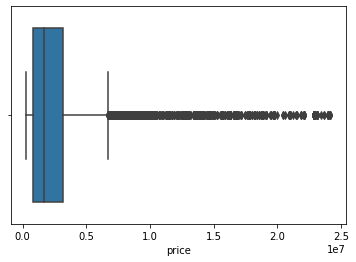

In [1129]:
sns.boxplot(train['price'])

In [1130]:
train.count()

property_type                19994
tenure                       19994
built_year                   19994
num_beds                     19994
num_baths                    19994
size_sqft                    19994
furnishing                   19994
available_unit_types         19994
total_num_units              19994
subzone                      19994
planning_area                19994
price                        19994
cc_distance                  19994
mrt_distance                 19994
primary_school_distance      19994
secondary_school_distance    19994
shop_distance                19994
population                   19994
area_size                    19994
log_price                    19994
dtype: int64

### size_sqft

<AxesSubplot:xlabel='size_sqft'>

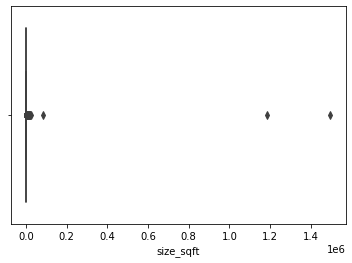

In [1131]:
sns.boxplot(x = train['size_sqft'])

In [1132]:
train['log_size_sqft'] = np.log(train['size_sqft'])
test['log_size_sqft'] = np.log(test['size_sqft'])

In [1133]:
train = train.drop(columns='size_sqft')
test = test.drop(columns='size_sqft')

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_size_sqft'>

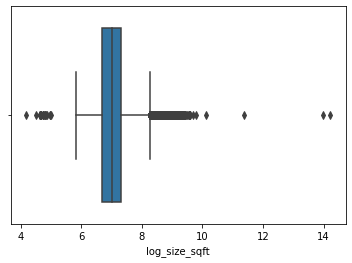

In [1134]:
sns.boxplot(train['log_size_sqft'])

<AxesSubplot:xlabel='log_size_sqft', ylabel='property_type'>

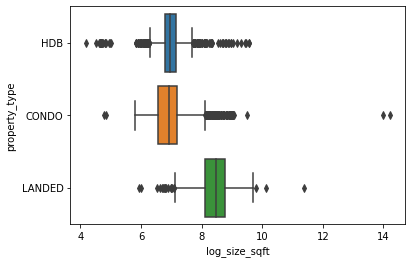

In [1135]:
sns.boxplot(x = train['log_size_sqft'], y = train['property_type'])

In [1136]:
train = train[train['log_size_sqft'] <9.7]

<AxesSubplot:xlabel='log_size_sqft', ylabel='property_type'>

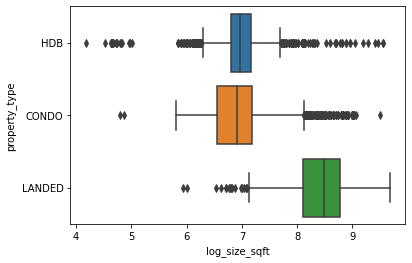

In [1137]:
sns.boxplot(x = train['log_size_sqft'], y = train['property_type'])

<AxesSubplot:xlabel='log_size_sqft', ylabel='property_type'>

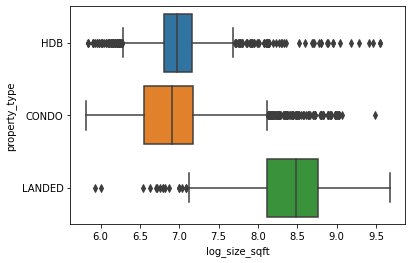

In [1138]:
train = train[train['log_size_sqft'] > 5.5]
sns.boxplot(x = train['log_size_sqft'], y = train['property_type'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_size_sqft'>

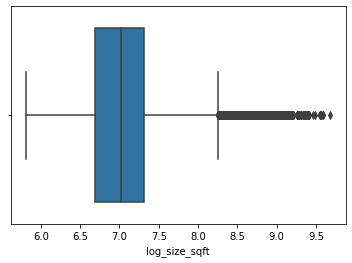

In [1139]:
sns.boxplot(train['log_size_sqft'])

### subzone and planning_area

In [1140]:
# adding regions
central = ['bishan', 'bukit merah', 'bukit timah', 'downtown core', 'geylang', 'kallang', 'marina east', 'marina south', 'marine parade', 'museum', 'newton',
           'novena', 'orchard', 'outram', 'queenstown', 'river valley', 'rochor', 'singapore river', 'southern islands', 'straits view', 'tanglin', 'toa payoh']

east = [ 'bedok', 'changi', 'changi bay', 'pasir ris', 'paya lebar', 'tampines']

north = ['central water catchment', 'lim chu kang', 'mandai', 'sembawang', 'simpang', 'sungei kadut', 'woodlands', 'yishun']

north_east = ['ang mo kio', 'hougang', 'north-eastern islands', 'punggol', 'seletar', 'sengkang', 'serangoon']

west = ['boon lay', 'bukit batok', 'bukit panjang', 'choa chu kang', 'clementi', 'jurong east', 'jurong west', 'pioneer', 'tengah', 'tuas', 'western islands', 'western water catchment']

In [1141]:
train['region'] = train['subzone'].copy()

In [1142]:
train['region'] = train['region'].replace(
    central,
    'central'
)

train['region'] = train['region'].replace(
    east,
    'east'
)

train['region'] = train['region'].replace(
    north,
    'north'
)

train['region'] = train['region'].replace(
    north_east,
    'north_east'
)

train['region'] = train['region'].replace(
    west,
    'west'
)

In [1143]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,furnishing,available_unit_types,total_num_units,subzone,planning_area,...,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,log_price,log_size_sqft,region
0,HDB,99-year leasehold,1988.0,3.0,2.0,unfurnished,5.0,116.0,yishun,yishun,...,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329,13.150951,7.016610,north
1,HDB,99-year leasehold,1992.0,4.0,2.0,unfurnished,6.0,296.0,serangoon,serangoon,...,2.400374,6.871207,8.310177,6.710202,6.710202,18660,3.5000,13.810900,7.362011,north_east
2,CONDO,freehold,2022.0,4.0,4.0,partial,5.0,56.0,marine parade,marine parade,...,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068,15.953810,8.029433,central
3,CONDO,freehold,2023.0,3.0,2.0,partial,5.0,638.0,bukit timah,bukit timah,...,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110,14.780972,6.864848,central
4,CONDO,99-year leasehold,2026.0,2.0,1.0,unfurnished,6.0,351.0,downtown core,downtown core,...,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092,14.383095,6.595781,central


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='region', ylabel='count'>

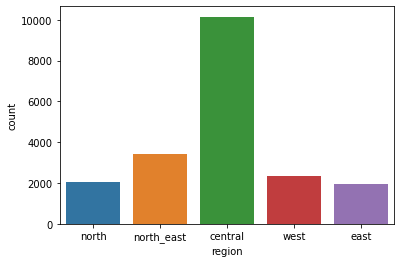

In [1144]:
sns.countplot(train['region'])

In [1145]:
test['region'] = test['subzone'].copy()
test['region'].unique()

array(['serangoon', 'pasir ris', 'museum', 'choa chu kang', 'toa payoh',
       'geylang', 'clementi', 'yishun', 'hougang', 'sengkang',
       'bukit batok', 'bukit panjang', 'woodlands', 'ang mo kio',
       'downtown core', 'queenstown', 'kallang', 'bukit timah', 'bedok',
       'river valley', 'novena', 'seletar', 'bishan', 'outram', 'tanglin',
       'jurong west', 'marine parade', 'punggol', 'sembawang',
       'singapore river', 'bukit merah', 'southern islands', 'changi',
       'newton', 'tampines', 'orchard', 'jurong east', 'tengah', 'rochor',
       'central water catchment', 'lim chu kang', 'mandai', 'boon lay'],
      dtype=object)

In [1146]:
test['region'] = test['region'].replace(
    central,
    'central'
)

test['region'] = test['region'].replace(
    east,
    'east'
)

test['region'] = test['region'].replace(
    north,
    'north'
)

test['region'] = test['region'].replace(
    north_east,
    'north_east'
)

test['region'] = test['region'].replace(
    west,
    'west'
)

test['region'].unique()

array(['north_east', 'east', 'central', 'west', 'north'], dtype=object)

In [1147]:
test.head()

,property_type,tenure,built_year,num_beds,num_baths,furnishing,available_unit_types,total_num_units,subzone,planning_area,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,log_size_sqft,region
0,CONDO,freehold,2022.0,1.0,1.0,unfurnished,6.0,250.0,serangoon,serangoon,1.046868,0.960436,13.993735,1.853769,1.853769,8490,1.1801,6.137727,north_east
1,CONDO,99-year leasehold,2017.0,3.0,3.0,unfurnished,6.0,463.0,pasir ris,pasir ris,8.581574,9.346690,13.709624,8.403509,8.403509,14700,2.3307,6.940222,east
2,CONDO,99-year leasehold,2007.0,1.0,1.0,partial,4.0,646.0,museum,museum,6.755363,6.710905,8.965840,6.503082,6.503082,24760,1.0619,6.345636,central
3,HDB,99-year leasehold,2017.0,3.0,2.0,unfurnished,5.0,900.0,choa chu kang,choa chu kang,14.229296,14.293216,12.559347,13.963584,13.963584,36080,3.0232,7.103322,west
4,HDB,99-year leasehold,1973.0,3.0,2.0,unfurnished,4.0,298.0,toa payoh,toa payoh,2.802424,2.077951,6.903112,3.079569,3.079569,15940,0.6847,6.841615,central


### Types

In [1148]:
train.dtypes

property_type                 object
tenure                        object
built_year                   float64
num_beds                     float64
num_baths                    float64
furnishing                    object
available_unit_types         float64
total_num_units              float64
subzone                       object
planning_area                 object
price                        float64
cc_distance                  float64
mrt_distance                 float64
primary_school_distance      float64
secondary_school_distance    float64
shop_distance                float64
population                     int64
area_size                    float64
log_price                    float64
log_size_sqft                float64
region                        object
dtype: object

### Remove Redundant features

In [1149]:
train.dtypes

property_type                 object
tenure                        object
built_year                   float64
num_beds                     float64
num_baths                    float64
furnishing                    object
available_unit_types         float64
total_num_units              float64
subzone                       object
planning_area                 object
price                        float64
cc_distance                  float64
mrt_distance                 float64
primary_school_distance      float64
secondary_school_distance    float64
shop_distance                float64
population                     int64
area_size                    float64
log_price                    float64
log_size_sqft                float64
region                        object
dtype: object

In [1150]:
test.count()

property_type                6966
tenure                       6966
built_year                   6966
num_beds                     6966
num_baths                    6966
furnishing                   6966
available_unit_types         6966
total_num_units              6966
subzone                      6966
planning_area                6966
cc_distance                  6966
mrt_distance                 6966
primary_school_distance      6966
secondary_school_distance    6966
shop_distance                6966
population                   6966
area_size                    6966
log_size_sqft                6966
region                       6966
dtype: int64

In [1151]:
test = test.drop(columns=['subzone','planning_area'])

In [1152]:
x_train = train.drop(columns=['subzone', 'planning_area','log_price'])
y_train = x_train.pop('price')

# Mining

#### Scale Numerical and Categorial columns

In [1153]:
num_selector = make_column_selector(dtype_include = [np.float64])
cat_selector = make_column_selector(dtype_include = [object])

In [1154]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_features = x_train.select_dtypes(include=numerics).columns

In [1155]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

In [1156]:
categorial = ['object']
categorical_features = x_train.select_dtypes(include=categorial).columns

In [1157]:
categorical_transformer = ce.OneHotEncoder(handle_unknown="ignore")

In [1158]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [1159]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_PR_AUC(clf, x, y):
    
    avg_precision = cross_val_score(clf, x, y, scoring="neg_mean_squared_error", cv=5, n_jobs=-1).mean()
    return (avg_precision)

### LightGBM

In [1160]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", lgb.LGBMClassifier())]
)

param_grid = {'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler()], 
              'classifier__n_estimators': list(range(15,30,5)),
              'classifier__learning_rate': [0.01,0.05, 0.1],
              'classifier__max_depth': list(range(1,4,1))
}

In [1168]:
grid_LGB = GridSearchCV(clf, param_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose = 2, n_jobs=-1) 


grid_LGB.fit(x_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END classifier__learning_rate=0.01, classifier__max_depth=1, classifier__n_estimators=15, preprocessor__num__scaler=MinMaxScaler(); total time= 3.1min
[CV] END classifier__learning_rate=0.01, classifier__max_depth=1, classifier__n_estimators=15, preprocessor__num__scaler=StandardScaler(); total time= 3.1min
[CV] END classifier__learning_rate=0.01, classifier__max_depth=1, classifier__n_estimators=15, preprocessor__num__scaler=MinMaxScaler(); total time= 3.1min
[CV] END classifier__learning_rate=0.01, classifier__max_depth=1, classifier__n_estimators=15, preprocessor__num__scaler=StandardScaler(); total time= 3.2min
[CV] END classifier__learning_rate=0.01, classifier__max_depth=1, classifier__n_estimators=15, preprocessor__num__scaler=StandardScaler(); total time= 3.2min
[CV] END classifier__learning_rate=0.01, classifier__max_depth=1, classifier__n_estimators=15, preprocessor__num__scaler=MinMaxScaler(); total time= 3.2min
[CV] END classifier__learning_rate=0.01, classifier__max_d

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['built_year', 'num_beds', 'num_baths', 'available_unit_types',
       'total_num_units', 'cc_distance', 'mrt_distance',
       'primary_school_distance', 'secondary_school_distance', 'shop_distance',
       'population', 'area_siz...
                                                                         Index(['property_type', 'tenure', 'furnishing', 'region'], dtype='object'))])),
                                       ('classifier', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.05, 0.1],
                         'classifier__max_depth': [1, 2, 3],
                         'classifier__n_estimators': [15, 20, 25],
                         'preprocessor__num__scaler': [StandardScaler(),
                                                       MinMaxScaler(),
                                                       RobustScaler(),
                                                       MaxAbsScaler()]},
             scoring='neg_mean_squared_error', verbose=2)

In [1169]:
grid_LGB.best_params_

{'classifier__learning_rate': 0.01,
 'classifier__max_depth': 2,
 'classifier__n_estimators': 25,
 'preprocessor__num__scaler': StandardScaler()}

### Random Forest

In [1178]:
from sklearn.ensemble import RandomForestRegressor
rf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestRegressor(random_state=2022))]
)

param_grid = {'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler()], 
              'classifier__n_estimators': list(range(50,150,50)),
              'classifier__min_samples_split': list(range(2,6,2)),
              'classifier__min_samples_leaf': list(range(1,4,1)),
              'classifier__max_depth': list(range(1,4,1)),
              'classifier__criterion': ['squared_error','absolute_error','poisson']
}

In [1179]:
random_rf = RandomizedSearchCV(rf, param_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose = 2, n_jobs=-1) 

random_rf.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__criterion=squared_error, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__min_samples_split=4, classifier__n_estimators=100, preprocessor__num__scaler=StandardScaler(); total time=   4.6s
[CV] END classifier__criterion=squared_error, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__min_samples_split=4, classifier__n_estimators=100, preprocessor__num__scaler=StandardScaler(); total time=   4.8s
[CV] END classifier__criterion=squared_error, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__min_samples_split=4, classifier__n_estimators=100, preprocessor__num__scaler=StandardScaler(); total time=   4.9s
[CV] END classifier__criterion=poisson, classifier__max_depth=1, classifier__min_samples_leaf=3, classifier__min_samples_split=4, classifier__n_estimators=100, preprocessor__num__scaler=MinMaxScaler(); total time=   2.3s
[CV] END classifier__criterion=

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['built_year', 'num_beds', 'num_baths', 'available_unit_types',
       'total_num_units', 'cc_distance', 'mrt_distance',
       'primary_school_distance', 'secondary_school_distance', 'shop_distance',
       'population', 'ar...
                   param_distributions={'classifier__criterion': ['squared_error',
                                                                  'absolute_error',
                                                                  'poisson'],
                                        'classifier__max_depth': [1, 2, 3],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         3],
                                        'classifier__min_samples_split': [2, 4],
                                        'classifier__n_estimators': [50, 100],
                                        'preprocessor__num__scaler': [StandardScaler(),
                                                                      MinMaxScaler(),
                                                                      RobustScaler(),
                                                                      MaxAbsScaler()]},
                   scoring='neg_mean_squared_error', verbose=2)

In [1180]:
random_rf.best_params_

{'preprocessor__num__scaler': StandardScaler(),
 'classifier__n_estimators': 100,
 'classifier__min_samples_split': 4,
 'classifier__min_samples_leaf': 2,
 'classifier__max_depth': 3,
 'classifier__criterion': 'squared_error'}

In [1181]:
random_rf.best_score_

-2315989530415.111

# Final Model

In [1183]:
final_model = random_rf.best_estimator_

In [1184]:
final_model.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['built_year', 'num_beds', 'num_baths', 'available_unit_types',
       'total_num_units', 'cc_distance', 'mrt_distance',
       'primary_school_distance', 'secondary_school_distance', 'shop_distance',
       'population', 'area_size', 'log_size_sqft'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['property_type', 'tenure', 'furnishing', 'region'], dtype='object'))])),
                ('classifier',
                 RandomForestRegressor(max_depth=3, min_samples_leaf=2,
                                       min_samples_split=4,
                                       random_state=2022))])

In [1185]:
predicted = final_model.predict(test)

In [1186]:
predictions_df=pd.DataFrame(data={"Predicted":predicted})

In [1187]:
#export as csv
predictions_df.to_csv('pred.csv', index_label = 'Id')